In [1]:
"""
In this notebook, we have augmented the dataset to create more datapoints which would represent
fraudulent transactions.

Then, we have implemented PCA and then used Random Forest Classifier to classify fraudulent transactions..
""";

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
from os import listdir
from os.path import isfile, join

loc = os.path.abspath("")
data_loc = f"{loc}/data"
print(data_loc)

C:\Users\ahmed\Desktop\IEEE-CIS-Fraud-Detection/data


In [4]:
%%time
train_identity   = pd.read_parquet(f"{data_loc}/train_identity.parquet.gzip")
train_transaction   = pd.read_parquet(f"{data_loc}/train_transaction.parquet.gzip")
test_identity   = pd.read_parquet(f"{data_loc}/test_identity.parquet.gzip")
test_transaction   = pd.read_parquet(f"{data_loc}/test_transaction.parquet.gzip")

Wall time: 1.67 s


Checking the number of total transactions in both the 'identity' and 'transaction' in train data:

In [5]:
print(train_transaction['TransactionID'].count())
print(train_identity['TransactionID'].count())

590540
144233


Merging the 'identity' and 'transaction' datasets together in one dataframe for both train and test data:

In [6]:
X_train = pd.merge(
    train_transaction, train_identity, how='left', on='TransactionID'
)

X_test = pd.merge(
    test_transaction, test_identity, how='left', on='TransactionID'  
)

In [7]:
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (590540, 434), Test shape: (506691, 433)


In [8]:
X_train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [9]:
"""
Total fraudulent transactions  (20,663) in our dataset is very less compared to non-fraudulent
transactions (569,877). Therefore, new datapoints must be created to represent more fraudulent transactions.
""";

<b>EDA:</b>

Checking number of total null values for each columns:

In [10]:
pd.set_option('display.max_rows', None)
X_train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [11]:
print(X_train.shape)
print(X_test.shape)

(590540, 434)
(506691, 433)


There are plenty of columns with large numbers of missing data. Here we are removing columns with >= 40% missing values.

In [12]:
# remove columns with over 40% missing data points
threshold = int(X_train.shape[0] * 0.4)
cols_with_missing_values = [col for col in X_train.columns if X_train[col].isnull().sum() >= threshold]
cols_with_missing_values
X_train.drop(cols_with_missing_values, axis = 1, inplace = True)
X_train.shape

(590540, 202)

In [13]:
# columns with id in test set are represented by "id-XX", whereas in the train set they are "id_XX"
# replace "-" with "_"
X_test.columns = X_test.columns.str.replace("-", "_")

In [14]:
X_test.drop(cols_with_missing_values, axis = 1, inplace = True)
X_test.shape

(506691, 201)

In [15]:
print(X_train.shape)
print(X_test.shape)

(590540, 202)
(506691, 201)


Checking number of total null values for each columns after dropping columns with upto 40 percent missing data:

In [16]:
X_train.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
P_emaildomain      94456
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D4                168922
D10                76022
D15                89113
M6                169360
V12                76073
V13                76073
V14                76073
V15                76073
V16                76073
V17                76073
V18                76073


In [17]:
pd.set_option('display.max_rows', 10)

In [18]:
#EDA:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 202 entries, TransactionID to V321
dtypes: float32(193), int32(4), object(5)
memory usage: 470.8+ MB


In [19]:
print(X_train.shape)
print(X_test.shape)

(590540, 202)
(506691, 201)


There are 5 object types that we need to convert to numerical data.

In [20]:
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
categorical_cols

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [21]:
print(X_train['ProductCD'].unique())
print(X_test['ProductCD'].unique())

['W' 'H' 'C' 'S' 'R']
['W' 'C' 'S' 'H' 'R']


In [22]:
print(X_train['card4'].unique())
print(X_test['card4'].unique())

['discover' 'mastercard' 'visa' 'american express' None]
['visa' 'mastercard' 'american express' 'discover' None]


In [23]:
print(X_train['P_emaildomain'].unique())
print(X_test['P_emaildomain'].unique())

[None 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
['gmail.com' 'aol.com' 'hotmail.com' None 'att.net' 'twc.com' 'yahoo.com'
 'verizon.net' 'anonymous.com' 'msn.com' 'q.com' 'outlook.com'
 'icloud.com' 'bellsouth.net' 'sbcglobal.net' 'web.de' 'live.com.

In [24]:
print(X_train['M6'].unique())
print(X_test['M6'].unique())

['T' 'F' None]
['F' 'T' None]


In [25]:
print(X_train['card6'].unique())
print(X_test['card6'].unique())

['credit' 'debit' None 'debit or credit' 'charge card']
['debit' 'credit' None 'charge card']


In [26]:
print(X_train['card6'].value_counts())

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64


In [27]:
# test set does not contain "debit or credit" data points for the "card6" column
# since there are only few of these, drop those rows from the train set
print(X_train.shape)
X_train.drop(X_train.loc[X_train['card6']=='debit or credit'].index, inplace=True)
print(X_train.shape)

(590540, 202)
(590510, 202)


<b>Handling categorical data:</b>

Since there are many different datapoints for 'P_emaildomain' we will be LabelEncoding them and the rest of the categorical columns will be one-hot encoded.

In [28]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [29]:
X_train['P_emaildomain'] = enc.fit_transform(X_train['P_emaildomain'])
X_train['P_emaildomain'];

X_test['P_emaildomain'] = enc.fit_transform(X_test['P_emaildomain'])
X_test['P_emaildomain'];

In [30]:
categorical_cols.remove('P_emaildomain')
categorical_cols

['ProductCD', 'card4', 'card6', 'M6']

Using One Hot Encoding to encode rest of the categorical columns:

In [31]:
X_train = pd.get_dummies(data=X_train, columns=categorical_cols)
X_test = pd.get_dummies(data=X_test, columns=categorical_cols)

In [32]:
print(X_train.shape)
print(X_test.shape)

(590510, 212)
(506691, 211)


Filling null values with mean in both train and test set:

In [33]:

X_train.fillna(value=X_train.mean(), inplace=True)
X_test.fillna(value=X_test.mean(), inplace=True)

Checking number of total null values for each columns after preprocessing:

In [34]:
print(X_train.isnull().sum())
print('__________________________')
print(X_train.isnull().sum().unique())

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
card1                0
                    ..
card6_charge card    0
card6_credit         0
card6_debit          0
M6_F                 0
M6_T                 0
Length: 212, dtype: int64
__________________________
[0]


In [35]:
print(X_test.isnull().sum())
print('__________________________')
print(X_test.isnull().sum().unique())

TransactionID        0
TransactionDT        0
TransactionAmt       0
card1                0
card2                0
                    ..
card6_charge card    0
card6_credit         0
card6_debit          0
M6_F                 0
M6_T                 0
Length: 211, dtype: int64
__________________________
[0]


In [36]:
# undersampling our dataset.
# dropping 80 percent of rows in training set where 'isFraud' == 0
print(X_train.shape)
X_train = X_train.drop(X_train[X_train['isFraud'] == 0].sample(frac=.92).index)
print(X_train.shape)

(590510, 212)
(66251, 212)


In [37]:
X_train['isFraud'].value_counts()

0    45588
1    20663
Name: isFraud, dtype: int64

<b>Train Test Split:</b>

In [38]:
X = X_train.drop('isFraud', axis=1).copy()

In [39]:
y = X_train['isFraud'].copy()

In [40]:
# train test-split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)
x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=0.25, random_state=42)

</b>Oversampling training set using SMOTE:</b>

In [41]:
from collections import Counter
Counter(y_train)

Counter({0: 34214, 1: 15474})

In [42]:
# from collections import Counter
# from imblearn.under_sampling import NearMiss
# ns=NearMiss(version=1, n_neighbors=3)
# x_train_aug, y_train_aug = ns.fit_resample(x_train,y_train)
# print("The number of classes before fit {}".format(Counter(y_train)))
# print("The number of classes after fit {}".format(Counter(y_train_aug)))

In [43]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_aug, y_train_aug = oversample.fit_resample(x_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_aug)))

The number of classes before fit Counter({0: 34214, 1: 15474})
The number of classes after fit Counter({0: 34214, 1: 34214})


<b>PCA:</b>

In [44]:
from sklearn.decomposition import PCA
pca = PCA().fit(x_train)

In [45]:
x_train.shape

(49688, 211)

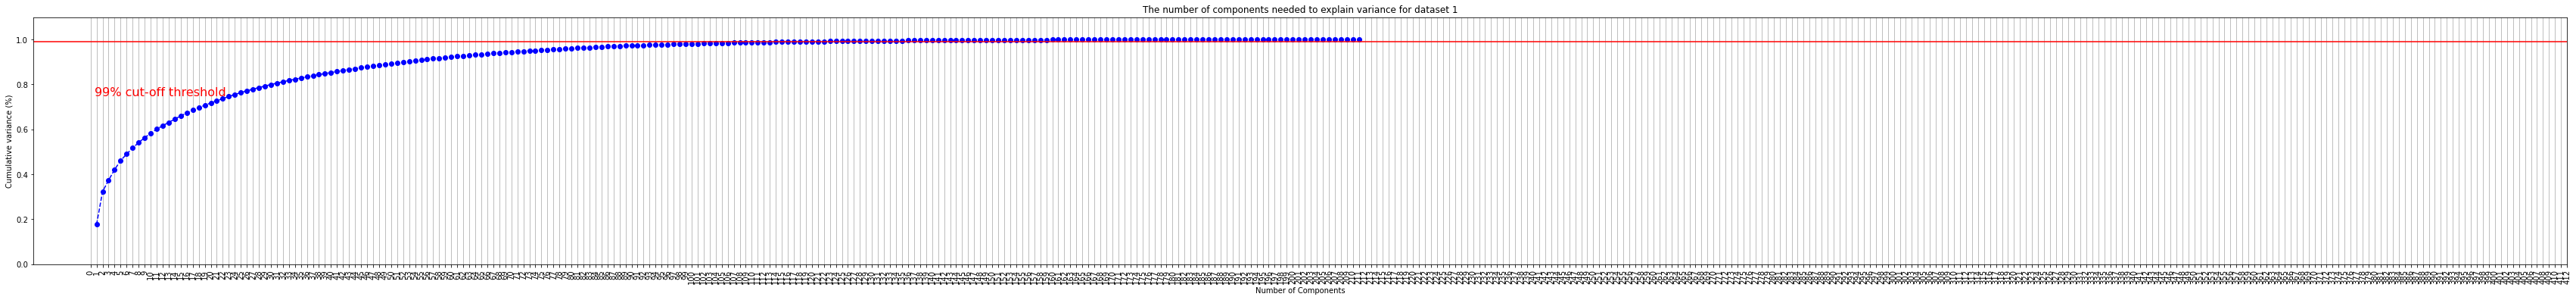

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (60,6)

fig, ax = plt.subplots()
xi = np.arange(1, 212, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 413, step=1)) #change from 0-based array index to 1-based human-readable label
plt.xticks(rotation=90)
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance for dataset 1')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.7, 0.75, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [47]:
model_pca = PCA(n_components=126)

pca_x_train = model_pca.fit_transform(x_train_aug)
pca_x_val  = model_pca.transform(x_val)
pca_X_test  = model_pca.transform(X_test_scaled)

In [48]:
print(x_train.shape)
print(x_val.shape)
print(X_test.shape)

(49688, 211)
(16563, 211)
(506691, 211)


In [49]:
print(pca_x_train.shape)
print(pca_x_val.shape)
print(pca_X_test.shape)

(68428, 126)
(16563, 126)
(506691, 126)


<b>Random Forest Classifier with PCA:</b>

Training, Predicting on validation set, Confusion Matix, AUC score, ROC curve:

RandomForest
____________________________
Accuracy: 0.8488800338103001
Precision: 0.7570826952526799
Recall: 0.7621892464829447
F1 Score: 0.759627388840872
____________________________
Confusion Matrix: 
 [[10105  1269]
 [ 1234  3955]]
____________________________
False Positive Rate: 0.11157024793388426
False Negative Rate: 0.23781075351705527
____________________________
AUC: 0.9013848616544655


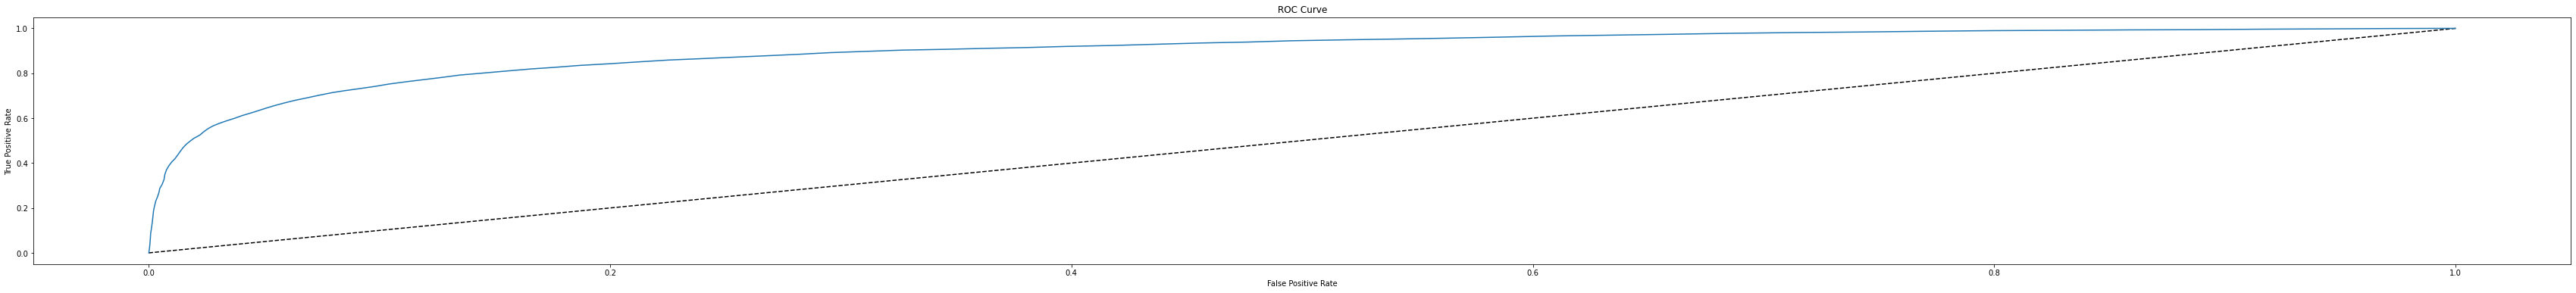

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import recall_score
from matplotlib import pyplot
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf_rfc=RandomForestClassifier(n_estimators=93, random_state=143)
clf_rfc.fit(pca_x_train,y_train_aug)
y_pred=clf_rfc.predict(pca_x_val)

print("RandomForest")
print("____________________________")
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("F1 Score:",metrics.f1_score(y_val, y_pred))
print("____________________________")
print("Confusion Matrix: \n", metrics.confusion_matrix(y_val, y_pred))

tpr = recall_score(y_val, y_pred) 
tnr = recall_score(y_val, y_pred, pos_label = 0) 
fpr = 1 - tnr
fnr = 1 - tpr
print("____________________________")
print("False Positive Rate:",fpr)
print("False Negative Rate:",fnr)

y_pred_prob = clf_rfc.predict_proba(pca_x_val)[:,1]

# Compute and print AUC score
print("____________________________")
print("AUC: {}".format(roc_auc_score(y_val, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
#cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
#print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Plot ROC curve
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

Predicting on test set:

In [51]:
y_pred_prob = clf_rfc.predict_proba(pca_X_test)[:,1]

Preparing csv file for kaggle submission:

In [52]:
sample_dataset = pd.read_csv('data/sample_submission.csv')
sample_dataset = sample_dataset.drop('isFraud', axis=1)
sample_dataset['isFraud'] = y_pred_prob.copy()
sample_dataset

,TransactionID,isFraud
0,3663549,0.258065
1,3663550,0.290323
2,3663551,0.505376
3,3663552,0.204301
4,3663553,0.161290
...,...,...
506686,4170235,0.440860
506687,4170236,0.505376
506688,4170237,0.322581
506689,4170238,0.365591


In [54]:
sample_dataset.to_csv('submission.csv', index=False) 